# Analyse der RSSI-/Pfadverlust-Messungen

Kurzbeschreibung
- Dieses Notebook lädt mehrere JSON-Scan-Dateien (verschiedene Entfernungen), berechnet den Pfadverlust und erstellt zusammenfassende Statistiken sowie ein Pfadverlust-Diagramm mit Fit eines Log-Distanz-Modells.

Wichtige Variablen
- TX_POWER_DBM (int): Sendestärke
- scans, scans_ts (DataFrame): Rohdaten / mit Zeitstempel
- agg (DataFrame): aggregierte Statistik pro anchor_id & distance_m
- pivot_pl (DataFrame): pivotierte mittlere Pfadverluste
- coeffs, slope, intercept, n, pl_fit, d_line: Fit-Parameter und Fit-Kurve

,anchor_id,distance_m,rssi,tx_power_dbm,path_loss_db
0,A-02,1,-79,9,88
1,A-02,1,-93,9,102
2,A-01,1,-87,9,96
3,A-01,1,-89,9,98
4,A-02,1,-79,9,88


,anchor_id,distance_m,rssi_mean,rssi_std,path_loss_mean,path_loss_std,count
0,A-01,1,-87.666667,1.618347,96.666667,1.618347,57
1,A-01,2,-91.125000,2.848316,100.125000,2.848316,32
2,A-01,4,-94.173913,1.581902,103.173913,1.581902,46
3,A-01,8,-97.589744,0.938026,106.589744,0.938026,39
4,A-01,10,-94.716667,0.640224,103.716667,0.640224,60
5,A-01,14,-94.841463,0.744851,103.841463,0.744851,82
6,A-02,1,-87.310345,5.864574,96.310345,5.864574,58
7,A-02,2,-86.380282,1.046985,95.380282,1.046985,71
8,A-02,4,-94.416667,0.869281,103.416667,0.869281,60
9,A-02,8,-96.147059,1.096326,105.147059,1.096326,68


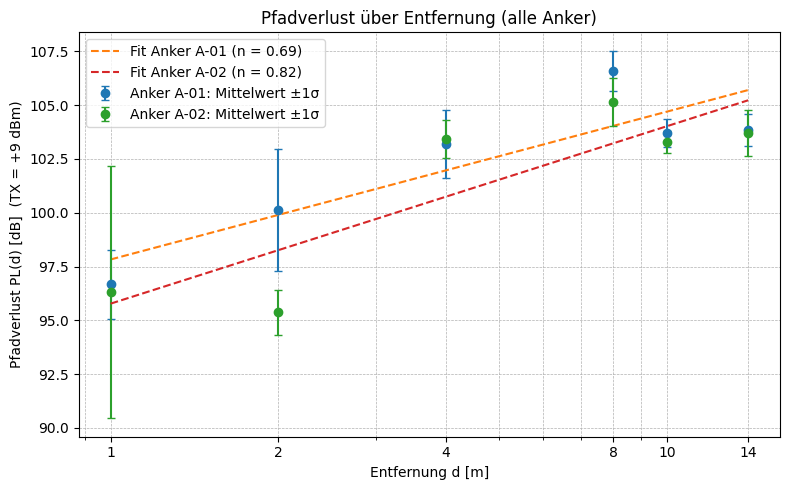

In [4]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. Konfiguration
# -------------------------------------------------------------------

distance_files = {
    1:  "1m_scans.json",
    2:  "2m_scans.json",
    4:  "4m_scans.json",
    8:  "8m_scans.json",
    10: "10m_scans.json",
    14: "14m_scans.json",
}

TX_POWER_DBM = 9

base_dir = Path(".")

# -------------------------------------------------------------------
# 2. Daten laden & Pfadverlust berechnen
# -------------------------------------------------------------------

all_frames = []

for dist_m, filename in distance_files.items():
    path = base_dir / filename
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Root-Objekt: { "table": "scans", "rows": [ ... ] }
    df = pd.DataFrame(data["rows"])
    df["distance_m"] = dist_m

    # Pfadverlust in dB: PL = P_tx(dBm) - P_rx(dBm)
    df["path_loss_db"] = df["tx_power_dbm"] - df["rssi"]

    all_frames.append(df)

scans = pd.concat(all_frames, ignore_index=True)

scans = scans[["anchor_id", "distance_m", "rssi", "tx_power_dbm", "path_loss_db"]]

display(scans.head())

# -------------------------------------------------------------------
# 3. Statistiken pro Entfernung & Anchor
# -------------------------------------------------------------------

agg = (
    scans
    .groupby(["anchor_id", "distance_m"])
    .agg(
        rssi_mean=("rssi", "mean"),
        rssi_std=("rssi", "std"),
        path_loss_mean=("path_loss_db", "mean"),
        path_loss_std=("path_loss_db", "std"),
        count=("rssi", "size"),
    )
    .reset_index()
)

display(agg)

# -------------------------------------------------------------------
# 4. Gemeinsames Pfadverlust-Diagramm (alle Anker, deutsche Beschriftung)
# -------------------------------------------------------------------

anchors = sorted(scans["anchor_id"].unique())
distanzen = sorted(scans["distance_m"].unique())

fig, ax = plt.subplots(figsize=(8, 5))

for anchor in anchors:
    df_anchor = agg[agg["anchor_id"] == anchor].copy()
    df_anchor = df_anchor.sort_values("distance_m")

    d = df_anchor["distance_m"].values.astype(float)
    pl = df_anchor["path_loss_mean"].values.astype(float)

    # Log-Distanz-Pfadverlust-Modell:
    x = np.log10(d)
    coeffs = np.polyfit(x, pl, 1)  # Steigung, Achsenabschnitt
    slope, intercept = coeffs
    n = slope / 10.0  # Ausbreitungskoeffizient

    d_line = np.linspace(d.min(), d.max(), 200)
    x_line = np.log10(d_line)
    pl_fit = np.polyval(coeffs, x_line)

    ax.errorbar(
        d,
        pl,
        yerr=df_anchor["path_loss_std"].values,
        fmt="o",
        capsize=3,
        label=f"Anker {anchor}: Mittelwert ±1σ",
    )

    ax.plot(
        d_line,
        pl_fit,
        linestyle="--",
        label=f"Fit Anker {anchor} (n = {n:.2f})",
    )

# x-Achse: logarithmisch, aber Ticks in vollen Metern
ax.set_xscale("log")
ax.set_xticks(distanzen)
ax.set_xticklabels([f"{int(d)}" for d in distanzen])

ax.set_xlabel("Entfernung d [m]")
ax.set_ylabel("Pfadverlust PL(d) [dB]  (TX = +9 dBm)")
ax.set_title("Pfadverlust über Entfernung (alle Anker)")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.show()
